# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [62]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
from sklearn.datasets import make_moons

Let's generate our dataset and take a look on it.

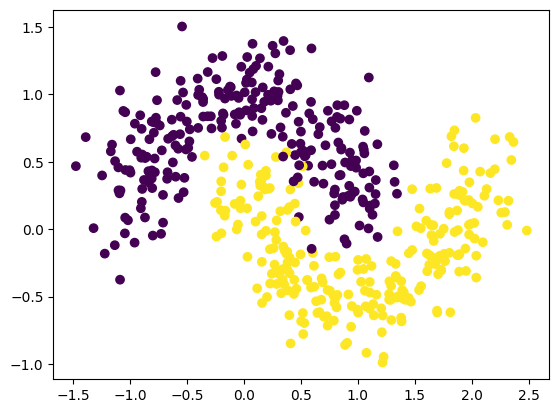

In [63]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [64]:
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from mlxtend.plotting import plot_decision_regions

import warnings
warnings.filterwarnings("ignore")

X_train, X_test, y_train, y_test = train_test_split(moons_points, moons_labels, test_size=0.2, random_state=42)

lr = LogisticRegression(tol=1e-3, C=10, solver='newton-cholesky', max_iter=500)  # add some params
svm = SVC(C=10, kernel="linear")  # here too

gs = gridspec.GridSpec(1, 2)
fig = plt.figure()

for clf, lab, i in zip([lr, svm],
                    ["Logistic Regression", "SVM"],
                    [0, 1]):
    clf.fit(X_train, y_train)
    ax = plt.subplot(gs[0, i])
    fig = plot_decision_regions(X=X_train, y=y_train, clf=clf)
    plt.title(lab)

y_pred_lr = lr.predict(X_test)
y_pred_svm = svm.predict(X_test)


print(f"Accuracy score logistic regression:{accuracy_score(y_test, y_pred_lr)}")
print(f"Accuracy score svm:{accuracy_score(y_test, y_pred_svm)}")
print(f"f1 score logistic regression:{f1_score(y_test, y_pred_lr)}")
print(f"f1 score svm:{f1_score(y_test, y_pred_svm)}")

Accuracy score logistic regression:0.86
Accuracy score svm:0.86
f1 score logistic regression:0.8679245283018868
f1 score svm:0.8679245283018868


Мы получили неплохую accuracy и f1, уже в момент приближения линейной моделью. Это означает, что большая часть оранжевых точек, которая лежит в синей области находится мало точек по сравнению с оранжевой областью. Значит можно предположить, что эти точки не сильно влияют на выборку, и дальнейшее приближение полиномами может переобучить модель.

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

In [65]:
svm_2 = SVC(C=10, kernel="poly")
svm_3 = SVC(C=10, kernel="rbf")
svm_4 = SVC(C=10, kernel="sigmoid")

gs = gridspec.GridSpec(1, 3)
fig = plt.figure()

for clf, lab, i in zip([svm_2, svm_3, svm_4],
                    ["poly", "rbf", "sigmoid"],
                    [0, 1, 2]):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Accuracy score svm {lab}: {accuracy_score(y_test, y_pred)}")
    ax = plt.subplot(gs[0, i])
    fig = plot_decision_regions(X=X_train, y=y_train, clf=clf)
    plt.title(lab)


Accuracy score svm poly: 0.91


Accuracy score svm rbf: 0.98
Accuracy score svm sigmoid: 0.64


Здесь видно, что лучше всего на ЭТИХ данных работает rbf, однако в ней площади областей разные, из-за чего эта модель на похожих данных может оказаться переобученной. Хорошо подходит модель poly с degree=3 (тут не видно, но она стоит по умолчанию см. документацию), сигмоиду для этой задачи явно использовать не стоит.

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

In [66]:
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.colors import ListedColormap

#убрал неинформативный столбец
poly_transform = PolynomialFeatures(degree=3, include_bias=False)
X_train_transform = poly_transform.fit_transform(X_train)
X_test_transform = poly_transform.fit_transform(X_test)

lr.fit(X_train_transform, y_train)
y_pred_lr_transform = lr.predict(X_test_transform)

print(lr.score(X_test_transform, y_test))

x_min, x_max = X_train_transform[:, 0].min() - 0.5, X_train_transform[:, 0].max() + 0.5
y_min, y_max = X_train_transform[:, 1].min() - 0.5, X_train_transform[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

cm_bright = ListedColormap(["#FF0000", "#0000FF"])
cm = plt.cm.RdBu

XX = np.array(list(zip(xx.ravel(), yy.ravel()))).reshape((-1, 2))

Z = lr.predict(poly_transform.transform(XX)).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=cm)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="black", s=25)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="black", s=25, marker='x')
plt.legend()
plt.show()

0.97


No handles with labels found to put in legend.


решение показывает лучшее accuracy чем svm 'poly' с degree=3.

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

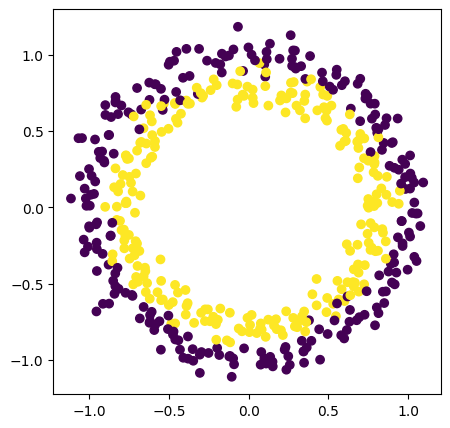

In [67]:
from sklearn.datasets import make_circles


circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

And even more:

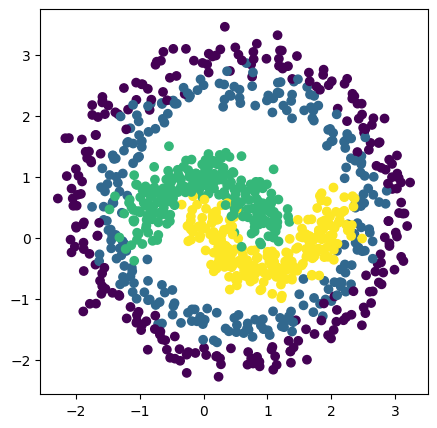

In [68]:
points = np.vstack((circles_points * 2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2))  # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

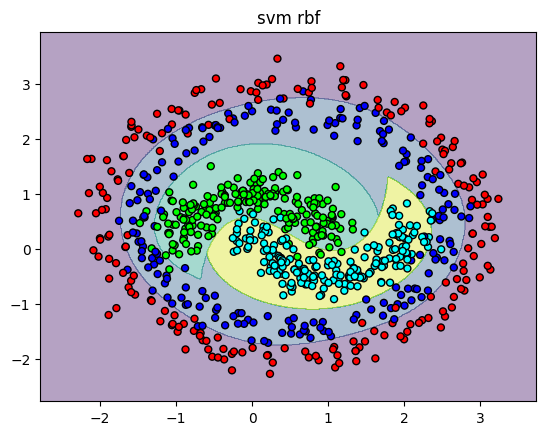

Logistic Regression Accuracy: 0.93
SVM RBF Accuracy: 0.945


In [69]:
#разбил данные на тренировку и тест
X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.2, random_state=42)

#создал обучающие модели
svm_linear = SVC(C=10, kernel="linear")
svm_poly = SVC(C=10, kernel="poly", degree=4)

#убрал неинформативный столбец
poly_transform = PolynomialFeatures(degree=4, include_bias=False)
X_train_transform = poly_transform.fit_transform(X_train)
X_test_transform = poly_transform.fit_transform(X_test)

#функция построения графиков
def plot_clf_graf(estimator, X, y, title=None, polytransform=False):
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    cm_bright = ListedColormap(["#FF0000", "#0000FF", "#00FF00", "#00FFFF"])


    XX = np.array(list(zip(xx.ravel(), yy.ravel()))).reshape((-1, 2))
    if (polytransform):
        Z = estimator.predict(poly_transform.transform(XX)).reshape(xx.shape)
    else:
        Z = estimator.predict(XX).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="black", s=25)
    plt.title(title)
    plt.show()

#строю графики
plot_clf_graf(lr, X_train_transform, y_train, "logistic regressin", polytransform=True)
plot_clf_graf(svm_rbf, X_train, y_train, "svm rbf")

#получаю accuracy
print(f"Logistic Regression Accuracy: {lr.score(X_test_transform, y_test)}")
print(f"SVM RBF Accuracy: {svm_rbf.score(X_test, y_test)}")